In [59]:
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import barnard_exact, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Load data

In [62]:
transplantation_date = pd.to_datetime('2024-02-02')

data = pd.read_csv('data.csv')
data['height_date_1'] = pd.to_datetime(data['height_date_1'], format="%d/%m/%Y")
data['height_date_2'] = pd.to_datetime(data['height_date_2'], format="%d/%m/%Y")
data = pd.merge(data, pd.get_dummies(data['bed_type'], drop_first=True, dtype=float), left_index=True, right_index=True)

display(data.head())
display(data.info())

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,out_survive,height_a_1,height_b_1,...,height_a_2,height_b_2,height_date_2,height_3,height_date_3,harvest_date,yield_g,wall_distance_e_mm,wall_distance_s_mm,no-dig
0,1,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,69.0,...,120.0,125.0,2024-04-01,230.0,4/05/2024,NaN,NaN,2000,3800,1.0
1,2,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,77.0,...,104.0,105.0,2024-04-01,270.0,4/05/2024,24/07/2024,197.4,2000,3200,0.0
2,3,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2500,3800,1.0
3,4,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,75.0,75.0,...,115.0,114.0,2024-04-01,270.0,4/05/2024,NaN,NaN,2500,3200,0.0
4,5,C,dig,NaN,NaN,15/01/2024,2/02/2024,1,131.0,135.0,...,205.0,206.0,2024-04-01,410.0,4/05/2024,17/06/2024,431.8,3000,3800,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   plant_id                   12 non-null     int64         
 1   bed_id                     12 non-null     object        
 2   bed_type                   12 non-null     object        
 3   distance_to_east_wall_mm   0 non-null      float64       
 4   distance_to_south_wall_mm  0 non-null      float64       
 5   sow_date                   12 non-null     object        
 6   transplant_date            12 non-null     object        
 7   out_survive                12 non-null     int64         
 8   height_a_1                 9 non-null      float64       
 9   height_b_1                 9 non-null      float64       
 10  height_date_1              9 non-null      datetime64[ns]
 11  height_a_2                 9 non-null      float64       
 12  height_b_2

None

# Live to harvest

In [3]:
survival_contingency = pd.crosstab(data.bed_type, data.out_survive)
survival_contingency

out_survive,0,1
bed_type,,
dig,1,5
no-dig,2,4


In [4]:
barnard_exact(survival_contingency, alternative='two-sided', pooled=False, n=32)
# Barnard becuase it is more powerful than Fisher and only one margin is fixed
# unpooled as unknown if variences are the same for each group. Pooling assumes the same varience. https://cran.r-project.org/web/packages/Exact/Exact.pdf , https://stats.stackexchange.com/questions/169864/which-test-for-cross-table-analysis-boschloo-or-barnard

BarnardExactResult(statistic=-0.6974858324629157, pvalue=0.7291618462276042)

## Height

In [5]:
for x in ['1', '2']:
    data['height_mean_'+x] = (data['height_a_'+x]+data['height_b_'+x])/2
    data['height_day_'+x] = data['height_date_'+x] - transplantation_date
    data['height_day_str_'+x] = data['height_day_'+x].apply(str)
data

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,out_survive,height_a_1,height_b_1,...,height_3,height_date_3,harvest_date,harvest_wt_g,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2
0,1,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,69.0,...,230.0,4/05/2024,NaN,NaN,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00
1,2,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,77.0,...,270.0,4/05/2024,NaN,NaN,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00
2,3,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
3,4,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,75.0,75.0,...,270.0,4/05/2024,NaN,NaN,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00
4,5,C,dig,NaN,NaN,15/01/2024,2/02/2024,1,131.0,135.0,...,410.0,4/05/2024,17/06/2024,431.8,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00
5,6,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
6,7,C,dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
7,8,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,114.0,...,340.0,4/05/2024,2/07/2024,319.2,113.5,34 days,34 days 00:00:00,166.0,59 days,59 days 00:00:00
8,9,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,112.0,...,270.0,4/05/2024,NaN,NaN,112.5,34 days,34 days 00:00:00,151.0,59 days,59 days 00:00:00
9,10,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,70.0,...,100.0,4/05/2024,NaN,NaN,70.0,34 days,34 days 00:00:00,91.0,59 days,59 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


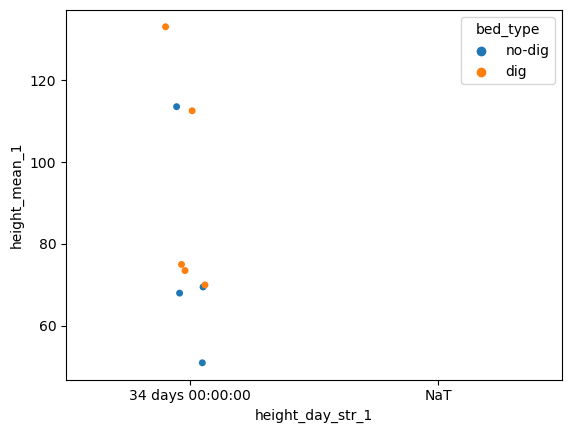

In [6]:
sns.stripplot(data=data, y='height_mean_1', x='height_day_str_1', hue='bed_type', jitter=True)
plt.show()

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


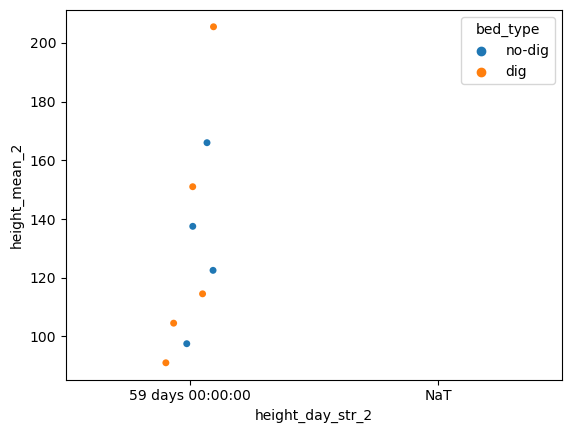

In [7]:
sns.stripplot(data=data, y='height_mean_2', x='height_day_str_2', hue='bed_type', jitter=True)
plt.show()

In [8]:
#30 (34) day
a = data[((data['bed_type']=='dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_1'].isna()==False))]['height_mean_1']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.9328677792620035, pvalue=0.3819387891001678, df=7.0)

In [9]:
#60 (59) day
a = data[((data['bed_type']=='dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
b = data[((data['bed_type']=='no-dig')&(data['height_mean_2'].isna()==False))]['height_mean_2']
ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0)

TtestResult(statistic=0.09135860860740895, pvalue=0.9297670668375285, df=7.0)

In [10]:
data['height_date_2']

0    2024-04-01
1    2024-04-01
2           NaT
3    2024-04-01
4    2024-04-01
5           NaT
6           NaT
7    2024-04-01
8    2024-04-01
9    2024-04-01
10   2024-04-01
11   2024-04-01
Name: height_date_2, dtype: datetime64[ns]

In [11]:
data

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,out_survive,height_a_1,height_b_1,...,height_3,height_date_3,harvest_date,harvest_wt_g,height_mean_1,height_day_1,height_day_str_1,height_mean_2,height_day_2,height_day_str_2
0,1,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,69.0,...,230.0,4/05/2024,NaN,NaN,69.5,34 days,34 days 00:00:00,122.5,59 days,59 days 00:00:00
1,2,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,77.0,...,270.0,4/05/2024,NaN,NaN,73.5,34 days,34 days 00:00:00,104.5,59 days,59 days 00:00:00
2,3,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
3,4,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,75.0,75.0,...,270.0,4/05/2024,NaN,NaN,75.0,34 days,34 days 00:00:00,114.5,59 days,59 days 00:00:00
4,5,C,dig,NaN,NaN,15/01/2024,2/02/2024,1,131.0,135.0,...,410.0,4/05/2024,17/06/2024,431.8,133.0,34 days,34 days 00:00:00,205.5,59 days,59 days 00:00:00
5,6,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
6,7,C,dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,NaT
7,8,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,114.0,...,340.0,4/05/2024,2/07/2024,319.2,113.5,34 days,34 days 00:00:00,166.0,59 days,59 days 00:00:00
8,9,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,112.0,...,270.0,4/05/2024,NaN,NaN,112.5,34 days,34 days 00:00:00,151.0,59 days,59 days 00:00:00
9,10,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,70.0,...,100.0,4/05/2024,NaN,NaN,70.0,34 days,34 days 00:00:00,91.0,59 days,59 days 00:00:00


In [12]:
measurements = pd.wide_to_long(data,['height_mean', 'height_day_str'], i='plant_id', j='measurement_number', sep='_').reset_index()
measurements

,plant_id,measurement_number,height_a_1,height_3,harvest_wt_g,height_date_1,out_survive,height_day_2,harvest_date,bed_type,...,height_day_1,height_a_2,distance_to_east_wall_mm,height_date_2,height_date_3,height_b_2,transplant_date,bed_id,height_mean,height_day_str
0,1,1,70.0,230.0,NaN,2024-03-07,1,59 days,NaN,no-dig,...,34 days,120.0,NaN,2024-04-01,4/05/2024,125.0,2/02/2024,A,69.5,34 days 00:00:00
1,2,1,70.0,270.0,NaN,2024-03-07,1,59 days,NaN,dig,...,34 days,104.0,NaN,2024-04-01,4/05/2024,105.0,2/02/2024,B,73.5,34 days 00:00:00
2,3,1,NaN,NaN,NaN,NaT,0,NaT,NaN,no-dig,...,NaT,NaN,NaN,NaT,NaN,NaN,2/02/2024,A,NaN,NaT
3,4,1,75.0,270.0,NaN,2024-03-07,1,59 days,NaN,dig,...,34 days,115.0,NaN,2024-04-01,4/05/2024,114.0,2/02/2024,B,75.0,34 days 00:00:00
4,5,1,131.0,410.0,431.8,2024-03-07,1,59 days,17/06/2024,dig,...,34 days,205.0,NaN,2024-04-01,4/05/2024,206.0,2/02/2024,C,133.0,34 days 00:00:00
5,6,1,NaN,NaN,NaN,NaT,0,NaT,NaN,no-dig,...,NaT,NaN,NaN,NaT,NaN,NaN,2/02/2024,D,NaN,NaT
6,7,1,NaN,NaN,NaN,NaT,0,NaT,NaN,dig,...,NaT,NaN,NaN,NaT,NaN,NaN,2/02/2024,C,NaN,NaT
7,8,1,113.0,340.0,319.2,2024-03-07,1,59 days,2/07/2024,no-dig,...,34 days,161.0,NaN,2024-04-01,4/05/2024,171.0,2/02/2024,D,113.5,34 days 00:00:00
8,9,1,113.0,270.0,NaN,2024-03-07,1,59 days,NaN,dig,...,34 days,151.0,NaN,2024-04-01,4/05/2024,151.0,2/02/2024,E,112.5,34 days 00:00:00
9,10,1,70.0,100.0,NaN,2024-03-07,1,59 days,NaN,dig,...,34 days,92.0,NaN,2024-04-01,4/05/2024,90.0,2/02/2024,E,70.0,34 days 00:00:00


c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


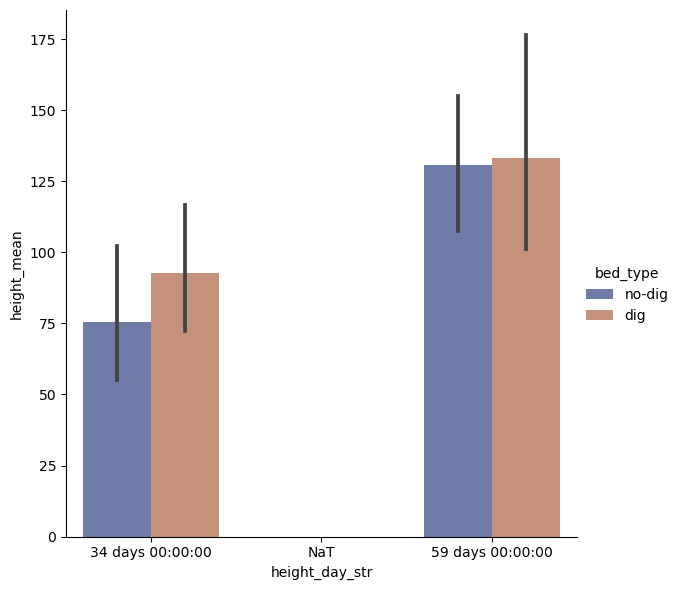

In [13]:
sns.catplot(
    data=measurements, kind="bar",
    x="height_day_str", y="height_mean", hue="bed_type",
    errorbar=("ci", 95), palette="dark", alpha=.6, height=6
)

# Yield

In [49]:
def drop_na(df):
    print(f'There are {len(df)} samples.')
    mask = df['yield_g'].isna()
    print(f'Excluding {sum(mask)} samples with nan yield.')
    df = df[mask==False]
    print(f'{len(df)} samples remain.')
    return df

def yield_analysis(df):
    df = drop_na(df)

    a = df[df['bed_type']=='dig']['yield_g']
    b = df[df['bed_type']=='no-dig']['yield_g']

    print()
    print(f'The Dig yield mean is {a.mean()} g')
    print(f'The No-dig yield mean is {b.mean()} g')

    display(ttest_ind(a=a, b=b, equal_var=True, nan_policy='raise', permutations=None, alternative='two-sided', trim=0))

yield_analysis(data)

There are 12 samples.
Excluding 7 samples with nan yield.
5 samples remain.

The Dig yield mean is 288.56666666666666 g
The No-dig yield mean is 235.64999999999998 g


TtestResult(statistic=0.47069697994417764, pvalue=0.6699659529985775, df=3.0)

In [63]:
def yield_linear_regression(df):
    df = drop_na(df)
    X = np.array(df[['no-dig', 'wall_distance_e_mm', 'wall_distance_s_mm']])
    y = np.array(df[['yield_g']])
    X = sm.add_constant(X)
    print(y)
    print(X)

    mod = sm.OLS(y, X)
    res = mod.fit()

    print(res.summary())
    
yield_linear_regression(data)

There are 12 samples.
Excluding 7 samples with nan yield.
5 samples remain.
[[197.4]
 [431.8]
 [319.2]
 [236.5]
 [152.1]]
[[1.0e+00 0.0e+00 2.0e+03 3.2e+03]
 [1.0e+00 0.0e+00 3.0e+03 3.8e+03]
 [1.0e+00 1.0e+00 3.5e+03 3.2e+03]
 [1.0e+00 0.0e+00 6.8e+03 2.8e+03]
 [1.0e+00 1.0e+00 7.5e+03 2.8e+03]]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1.376
Date:                Wed, 24 Jul 2024   Prob (F-statistic):              0.543
Time:                        15:23:54   Log-Likelihood:                -25.977
No. Observations:                   5   AIC:                             59.95
Df Residuals:                       1   BIC:                             58.39
Df Model:                           3                                 

c:\Users\acbre\anaconda3\envs\default\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [46]:
data = pd.merge(data, pd.get_dummies(data['bed_type'], drop_first=True), left_index=True, right_index=True)

,plant_id,bed_id,bed_type,distance_to_east_wall_mm,distance_to_south_wall_mm,sow_date,transplant_date,out_survive,height_a_1,height_b_1,...,height_a_2,height_b_2,height_date_2,height_3,height_date_3,harvest_date,yield_g,wall_distance_e_mm,wall_distance_s_mm,no-dig
0,1,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,69.0,...,120.0,125.0,2024-04-01,230.0,4/05/2024,NaN,NaN,2000,3800,True
1,2,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,77.0,...,104.0,105.0,2024-04-01,270.0,4/05/2024,24/07/2024,197.4,2000,3200,False
2,3,A,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,2500,3800,True
3,4,B,dig,NaN,NaN,15/01/2024,2/02/2024,1,75.0,75.0,...,115.0,114.0,2024-04-01,270.0,4/05/2024,NaN,NaN,2500,3200,False
4,5,C,dig,NaN,NaN,15/01/2024,2/02/2024,1,131.0,135.0,...,205.0,206.0,2024-04-01,410.0,4/05/2024,17/06/2024,431.8,3000,3800,False
5,6,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,3000,3200,True
6,7,C,dig,NaN,NaN,15/01/2024,2/02/2024,0,NaN,NaN,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,3500,3800,False
7,8,D,no-dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,114.0,...,161.0,171.0,2024-04-01,340.0,4/05/2024,2/07/2024,319.2,3500,3200,True
8,9,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,113.0,112.0,...,151.0,151.0,2024-04-01,270.0,4/05/2024,24/07/2024,236.5,6800,2800,False
9,10,E,dig,NaN,NaN,15/01/2024,2/02/2024,1,70.0,70.0,...,92.0,90.0,2024-04-01,100.0,4/05/2024,NaN,NaN,6800,2200,False
